### Download LFW datasets

In [11]:
! kaggle datasets download -d atulanandjha/lfwpeople

 99%|███████████████████████████████████████▊| 231M/232M [00:06<00:00, 50.4MB/s]
100%|████████████████████████████████████████| 232M/232M [00:06<00:00, 39.8MB/s]


In [35]:
! unzip lfwpeople.zip

Archive:  lfwpeople.zip
  inflating: lfw-funneled.tgz        
  inflating: pairs.txt               
  inflating: pairsDevTest.txt        
  inflating: pairsDevTrain.txt       


In [3]:
# import tarfile
  
# # open file
file = tarfile.open('lfw-funneled.tgz')
  
# # extracting file
# file.extractall('LFW_Folder')
  
# file.close()

In [1]:
! kaggle datasets download -d hereisburak/pins-face-recognition

Traceback (most recent call last):
  File "/root/miniconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/root/miniconda3/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/root/miniconda3/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [12]:
! kaggle datasets download -d hereisburak/pins-face-recognition

 99%|███████████████████████████████████████▍| 367M/372M [00:12<00:00, 41.5MB/s]
100%|████████████████████████████████████████| 372M/372M [00:12<00:00, 30.8MB/s]


In [14]:
# ! unzip pins-face-recognition.zip

In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os

In [80]:
#have a folder to store all the tartget images, and another folder for non-target images
os.mkdir('target')
os.mkdir('non_target')

In [81]:
target_train_dir = 'target/train/'
target_val_dir='target/val/'
target_test_dir='target/test/'
os.mkdir(target_train_dir)
os.mkdir(target_val_dir)
os.mkdir(target_test_dir)

In [82]:
non_target_train_dir = 'non_target/train/'
non_target_val_dir='non_target/val/'
non_target_test_dir='non_target/test/'
os.mkdir(non_target_train_dir)
os.mkdir(non_target_val_dir)
os.mkdir(non_target_test_dir)

In [83]:
lfw_dir = "LFW_Folder/lfw_funneled/"

In [84]:
lfw_list = os.listdir(lfw_dir)

In [85]:
len(lfw_list)

5760

5760 person in totall

In [86]:
lfw_list[0]

'George_HW_Bush'

In [87]:
lfw_list = [item for item in lfw_list if not '.txt' in item ]

<AxesSubplot:>

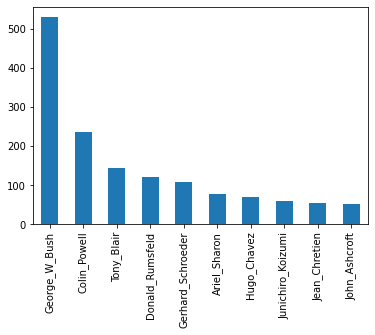

In [88]:
name_im_c = {}
for name in lfw_list:
    folder_dir = os.path.join(lfw_dir,name)
    img_count = len(os.listdir(folder_dir))
    name_im_c[name] = img_count
name_im_c = pd.Series(name_im_c)
name_im_c.sort_values(ascending=False)[:10].plot(kind='bar')

In [89]:
print('%.2f'%(name_im_c.value_counts().to_dict()[1]/len(lfw_list)))

0.71


In [90]:
least_num = 20
max_num = 80
chosen_name = []
not_chosen_name = []
for item in lfw_list:
    folder_dir = os.path.join(lfw_dir,item)
    img_count = len(os.listdir(folder_dir))
    if img_count >= least_num and img_count <= max_num:
        chosen_name.append(item)
    else:
        not_chosen_name.append(item)
print(len(chosen_name))

57


randomly chosing 50 detecting target people. Let's see how many pictures of each person

In [91]:
import numpy as np
np.random.shuffle(chosen_name)
target_names=chosen_name[:50]
non_target=not_chosen_name[:30]

<AxesSubplot:>

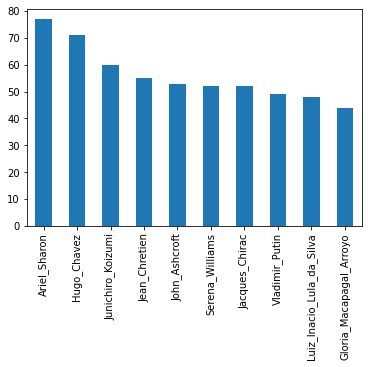

In [92]:
name_im_c = {}
for name in target_names:
    folder_dir = os.path.join(lfw_dir,name)
    img_count = len(os.listdir(folder_dir))
    name_im_c[name] = img_count
name_im_c = pd.Series(name_im_c)
name_im_c.sort_values(ascending=False)[:10].plot(kind='bar')

In [93]:
int(np.average(name_im_c))

33

Averagely, each choosen target has 31 corresponding pictures, must be bigger than 5 pictures for each target.

In [94]:
non_target

['George_HW_Bush',
 'Curtis_Strange',
 'Marc_Grossman',
 'Michael_Schumacher',
 'Paul_ONeill',
 'John_Manley',
 'Darren_Clarke',
 'Mstislav_Rostropovich',
 'Larry_Ellison',
 'Paul_Lo_Duca',
 'Colin_Montgomerie',
 'Fernando_Leon_de_Aranoa',
 'Arminio_Fraga',
 'Bob_Huggins',
 'Nelson_Mandela',
 'Gordon_Brown',
 'Heath_Ledger',
 'Shannyn_Sossamon',
 'Mike_Tyson',
 'Edward_James_Olmos',
 'Alex_Barros',
 'Daniela_Cicarelli',
 'Herta_Daeubler-Gmelin',
 'Gerhard_Schroeder',
 'Audrey_Sauret',
 'Dawn_Staley',
 'Will_Smith',
 'Felipe_Perez_Roque',
 'Juan_Ignacio_Chela',
 'Li_Peng']

randomly chosing 30 non target people.

In [95]:
print(len(target_names),len(non_target))

50 30


In [96]:
import shutil
base_dir = lfw_dir
device = "cuda" if torch.cuda.is_available() else "cpu"
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False, device='cuda:0')

for target in target_names:
    fold_name= target
    src_folder = os.path.join(base_dir,fold_name)
    img_list=os.listdir(src_folder)
    img_count = len(img_list)
    np.random.shuffle(img_list)
    img_train_list = img_list[:int(0.8*img_count)]
    img_val_list = img_list[int(0.8*img_count):int(0.9*img_count)]
    img_test_list=img_list[int(0.9*img_count):]
    #target_train_set
    for file in img_train_list:
        src_dir =fold_name+'/'+file
        src = os.path.join(base_dir,src_dir)
        dst = os.path.join(target_train_dir,file)
        #crop img and save img
        img = cv2.imread(src)
        frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Detect face
        face = mtcnn(frame)
        # print(type(face))
        face = face.permute(1, 2, 0).int().numpy()
        face = face[...,::-1].copy()
        cv2.imwrite(dst,face)
    
    for file in img_val_list:
        src_dir =fold_name+'/'+file
        src = os.path.join(base_dir,src_dir)
        dst = os.path.join(target_val_dir,file)
        #crop img and save img
        img = cv2.imread(src)
        frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Detect face
        face = mtcnn(frame)
        face = face.permute(1, 2, 0).int().numpy()
        face = face[...,::-1].copy()
        cv2.imwrite(dst,face)
        # shutil.copyfile(src, dst)
    for file in img_test_list:
        src_dir =fold_name+'/'+file
        src = os.path.join(base_dir,src_dir)
        dst = os.path.join(target_test_dir,file)
        #crop img and save img
        img = cv2.imread(src)
        frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Detect face
        face = mtcnn(frame)
        face = face.permute(1, 2, 0).int().numpy()
        face = face[...,::-1].copy()
        cv2.imwrite(dst,face)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [97]:
for non_target_name in non_target[:24]:
    fold_name= non_target_name
    src_folder = os.path.join(base_dir,fold_name)
    img_list=os.listdir(src_folder)
    rand_ind = np.random.randint(0,len(img_list))
    #target_train_set
    src_dir =fold_name+'/'+img_list[rand_ind]
    src = os.path.join(base_dir,src_dir)
    # print(src)
    dst = os.path.join('non_target/train/',img_list[rand_ind])
    img = cv2.imread(src)
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Detect face
    face = mtcnn(frame)
    face = face.permute(1, 2, 0).int().numpy()
    face = face[...,::-1].copy()
    cv2.imwrite(dst,face)

    
for non_target_name in non_target[24:27]:
    fold_name= non_target_name
    src_folder = os.path.join(base_dir,fold_name)
    img_list=os.listdir(src_folder)
    rand_ind = np.random.randint(0,len(img_list))
    #target_train_set
    src_dir =fold_name+'/'+img_list[rand_ind]
    src = os.path.join(base_dir,src_dir)
    dst = os.path.join(non_target_test_dir,img_list[rand_ind])
    img = cv2.imread(src)
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Detect face
    face = mtcnn(frame)
    face = face.permute(1, 2, 0).int().numpy()
    face = face[...,::-1].copy()
    cv2.imwrite(dst,face)

for non_target_name in non_target[27:]:
    fold_name= non_target_name
    src_folder = os.path.join(base_dir,fold_name)
    img_list=os.listdir(src_folder)
    rand_ind = np.random.randint(0,len(img_list))
    #target_train_set
    src_dir =fold_name+'/'+img_list[rand_ind]
    src = os.path.join(base_dir,src_dir)
    dst = os.path.join(non_target_val_dir,img_list[rand_ind])
    img = cv2.imread(src)
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Detect face
    face = mtcnn(frame)
    face = face.permute(1, 2, 0).int().numpy()
    face = face[...,::-1].copy()
    cv2.imwrite(dst,face)

In [98]:
target_train_list = os.listdir('target/train/')

In [99]:
label_target_train  = np.zeros(len(target_train_list))
for i in range(len(target_train_list)):
    for name in target_names:
        if name in target_train_list[i]:
            label_target_train[i] = target_names.index(name)

In [100]:
non_target_train_list = os.listdir('non_target/train/')

In [101]:
non_target_train_list = [item for item in non_target_train_list if '.jpg' in item]
label_non_target_train = [50 for i in range(len(non_target_train_list))]

In [102]:
int(len(target_train_list)/50)

26

In [103]:
len(non_target_train_list)

24

In [104]:
train_list = target_train_list + non_target_train_list
label_train_list =label_target_train.astype(int).tolist() + label_non_target_train

In [105]:
len(label_train_list)

1338

In [106]:
dict_train = {'img_train':train_list,'label_train':label_train_list}

In [107]:
train_csv = pd.DataFrame(dict_train)
train_csv.to_csv('train.csv',index=False)

In [108]:
train_csv

,img_train,label_train
0,Lleyton_Hewitt_0024.jpg,0
1,Lleyton_Hewitt_0010.jpg,0
2,Lleyton_Hewitt_0031.jpg,0
3,Lleyton_Hewitt_0015.jpg,0
4,Lleyton_Hewitt_0017.jpg,0
...,...,...
1333,Edward_James_Olmos_0002.jpg,50
1334,Alex_Barros_0001.jpg,50
1335,Daniela_Cicarelli_0001.jpg,50
1336,Herta_Daeubler-Gmelin_0001.jpg,50


In [109]:
target_val_list = os.listdir('target/val/')
label_target_val  = np.zeros(len(target_val_list))
for i in range(len(target_val_list)):
    for name in target_names:
        if name in target_val_list[i]:
            label_target_val[i] = target_names.index(name)
non_target_val_list = os.listdir('non_target/val/')
non_target_val_list = [item for item in non_target_val_list if '.jpg' in item]
label_non_target_val = [50 for i in range(len(non_target_val_list))]
print(len(target_val_list),len(non_target_val_list))
val_list = target_val_list + non_target_val_list
label_val_list =label_target_val.astype(int).tolist() + label_non_target_val
dict_val = {'img_train':val_list,'label_train':label_val_list}
val_csv = pd.DataFrame(dict_val)
val_csv.to_csv('val.csv',index=False)

162 3


In [110]:
target_test_list = os.listdir('target/test/')
label_target_test  = np.zeros(len(target_test_list))
for i in range(len(target_test_list)):
    for name in target_names:
        if name in target_test_list[i]:
            label_target_test[i] = target_names.index(name)
non_target_test_list = os.listdir('non_target/test/')
non_target_test_list = [item for item in non_target_test_list if '.jpg' in item]
label_non_target_test = [50 for i in range(len(non_target_test_list))]
print(len(target_test_list),len(non_target_test_list))
test_list = target_test_list + non_target_test_list
label_test_list =label_target_test.astype(int).tolist() + label_non_target_test
dict_test = {'img_train':test_list,'label_train':label_test_list}
test_csv = pd.DataFrame(dict_test)
test_csv.to_csv('test.csv',index=False)

192 3


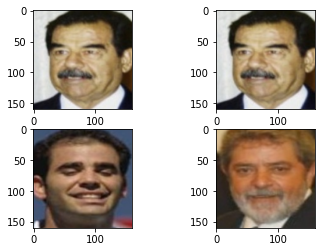

In [111]:
f, axarr = plt.subplots(2,2)
imgs = []
for i in range(4):
    index = np.random.randint(len(os.listdir('target/test/')),size = 1)
    img = cv2.imread(os.path.join('target/test/',os.listdir('target/test/')[index.item()]))
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(frame)

axarr[0,0].imshow(imgs[0])
axarr[0,1].imshow(imgs[1])
axarr[1,0].imshow(imgs[2])
axarr[1,1].imshow(imgs[3])

### Custom Dataset and Define dataloaders

In [151]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

In [140]:
img = torchvision.io.read_image(os.path.join('target/train/',os.listdir('target/train/')[1]))

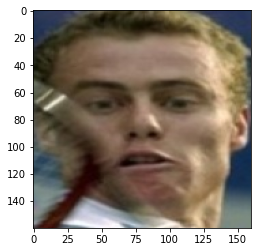

In [141]:
plt.imshow(img.permute(1,2,0))

In [116]:
os.mkdir('train')
import shutil
for img_dir in list(os.listdir('target/train/')):
    if '.jpg' in img_dir:
        src = os.path.join('target/train/',img_dir)
        dst = os.path.join('train/',img_dir)
        shutil.copyfile(src,dst)
for img_dir in list(os.listdir('non_target/train/')):
    if '.jpg' in img_dir:
        src = os.path.join('non_target/train/',img_dir)
        dst = os.path.join('train/',img_dir)
        shutil.copyfile(src,dst)

In [117]:
os.mkdir('test')
for img_dir in list(os.listdir('target/test/')):
    if '.jpg' in img_dir:
        src = os.path.join('target/test/',img_dir)
        dst = os.path.join('test/',img_dir)
        shutil.copyfile(src,dst)
for img_dir in list(os.listdir('non_target/test/')):
    if '.jpg' in img_dir:
        src = os.path.join('non_target/test/',img_dir)
        dst = os.path.join('test/',img_dir)
        shutil.copyfile(src,dst)

In [118]:
os.mkdir('val')
for img_dir in list(os.listdir('target/val/')):
    if '.jpg' in img_dir:
        src = os.path.join('target/val/',img_dir)
        dst = os.path.join('val/',img_dir)
        shutil.copyfile(src,dst)
for img_dir in list(os.listdir('non_target/val/')):
    if '.jpg' in img_dir:
        src = os.path.join('non_target/val/',img_dir)
        dst = os.path.join('val/',img_dir)
        shutil.copyfile(src,dst)

### trainset trainloader

In [152]:
from facenet_pytorch import fixed_image_standardization, training
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

trainset = CustomImageDataset(csv_file = 'train.csv',
                              root_dir='train/',
                             transform = preprocessing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 160, 160])
1 torch.Size([3, 160, 160])
2 torch.Size([3, 160, 160])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 160, 160])


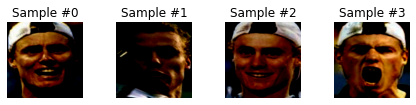

In [143]:
for i in range(len(trainset)):
    data,label = trainset[i]

    print(i, data.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(data.permute(1,2,0))
    if i == 3:
        plt.show()
        break

In [153]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8,
                        shuffle=True, num_workers=0)

In [155]:
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=True, num_workers=0)
valset = CustomImageDataset(csv_file = 'val.csv',
                              root_dir='val/',
                             transform = preprocessing)
valloader = DataLoader(valset, batch_size=8,
                        shuffle=True, num_workers=0)

### Define Fintuning Models and Train

In [161]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 51
).to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [162]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
epochs = 50
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, valloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, trainloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, valloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    21/21   | loss:    4.1746 | fps:   92.5615 | acc:    0.0119   

Epoch 1/50
----------
Train |   168/168  | loss:    3.1664 | fps:   73.2575 | acc:    0.2292   
Valid |    21/21   | loss:    2.7949 | fps:  102.2651 | acc:    0.3036   

Epoch 2/50
----------
Train |   168/168  | loss:    2.1001 | fps:   65.6362 | acc:    0.4226   
Valid |    21/21   | loss:    1.9750 | fps:   89.0091 | acc:    0.5214   

Epoch 3/50
----------
Train |   168/168  | loss:    1.4822 | fps:   70.8803 | acc:    0.5952   
Valid |    21/21   | loss:    1.5475 | fps:  109.8305 | acc:    0.5810   

Epoch 4/50
----------
Train |   168/168  | loss:    1.1873 | fps:   68.3011 | acc:    0.6704   
Valid |    21/21   | loss:    1.4302 | fps:  115.0773 | acc:    0.6083   

Epoch 5/50
----------
Train |   168/168  | loss:    0.8974 | fps:   70.8039 | acc:    0.7448   
Valid |    21/21   | loss:    0.9159 | fps:  104.6036 | acc:    0.7548   

Epoch 6/50
----------
Train |   168/168  | loss: 

NameError: name 'model' is not defined

In [163]:
torch.save(resnet.state_dict(),'./savedmodels/model_parameter.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 22, Predicted:5
False Sample 1: True Labels: 23, Predicted:3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 1, Predicted:19
False Sample 1: True Labels: 23, Predicted:50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 50, Predicted:36
False Sample 1: True Labels: 4, Predicted:2
False Sample 1: True Labels: 50, Predicted:10
False Sample 1: True Labels: 13, Predicted:35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 12, Predicted:34
False Sample 1: True Labels: 37, Predicted:48


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 43, Predicted:16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 50, Predicted:11
False Sample 1: True Labels: 2, Predicted:28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 41, Predicted:24
False Sample 1: True Labels: 14, Predicted:47


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False Sample 1: True Labels: 44, Predicted:50
Accuracy of the network on the 1000 test images: 91 %


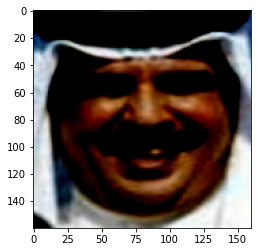

In [182]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if 0 in (predicted == labels):
            determinant = predicted == labels
            for j in range(len(determinant)):
                if determinant[j] == False:
                    print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
                    plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')